<a href="https://colab.research.google.com/github/isavida/football-task/blob/team-classification/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.3/716.3 kB 9.3 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
import os

from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
from ultralytics import YOLO

#Setup

In [4]:
def git_setup(token):
  os.system(f"git config --global user.email 'isabel.vidaurre@hotmail.com'")
  os.system(f"git config --global user.name 'isavida'")
  os.system(f"git clone https://{token}@github.com/isavida/football-task.git")
  os.chdir("football-task")

In [5]:
git_setup('123123')

# Introduction
The task consists of taking as input a video footage and output:


*   A JSONL file that contains a row for each 5th frame with the number of players from home-team and away-team, numbers of referees and position of the ball.
*   A video with the team players with the bounding boxes of detections
classified according to their team and the annotation of the ball when detected


It is decided to do the player detection task first, as the data for the jsonl file can be obtained from these detections.



#Players detection

In [6]:
def inference_video(model, filename):
    results = model.track(source=f"data/{filename}.mp4", save = True, name=f"{filename}_result", conf=0.1)
    return results

In [ ]:
model = YOLO('yolov8n.pt')
results = inference_video(model, "clip_1")

##Team classification
To correctly classify each team, we should find the team colors.

### K-means approach
We can delete all the colors that aren't part of the bounding boxes and apply a filter to remove the green color (so as not to consider the grass in the field), then we can apply the k-means algorithm to obtain the most relevant colors.

In [8]:
def get_upper_left_corner_location(coordinates):
  ''' YOLO x-y coordinates refers to the center of the detected image.
  This functions gets the upper-left corner as a util in order to create the mask of the bounding boxes '''
  center_x, center_y, w, h = coordinates
  x= int(center_x - w/2)
  y= int(center_y - h/2)

  return x, y


In [90]:
def get_persons_images(orig_img, bounding_boxes):
  persons=[]
  ## remove green
  hsv = cv2.cvtColor(orig_img, cv2.COLOR_BGR2HSV)
  green_mask = cv2.inRange(hsv, (35, 35, 35), (70, 255,255))
  inverted_green_mask= cv2.bitwise_not(green_mask)
  processed_img = cv2.bitwise_and(orig_img,orig_img, mask=inverted_green_mask)

  for box in bounding_boxes:
    x, y, w, h=map(int, box.xywh.tolist()[0])
    x,y = get_upper_left_corner_location([int(x),y,w,h])

    if box.cls==0: #cls 0 corresponds to person
      person=processed_img[y:y+h,x:x+w]
      persons.append(person)

  return persons

In [37]:
#Obtaining the frame with more person detections
max=0
max_id=0
for i,r in enumerate(results):
  length = len(r.boxes.cls==0)
  if length>max:
    max=length
    max_id=i

222 20


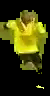

In [91]:
persons=get_persons_images(results[max_id].orig_img, results[max_id].boxes)
person=persons[0]
cv2_imshow(person)

In [114]:
persons_wo_black =[]
for person in persons:
  person_wo_black = person[person.sum(axis=2)!=0].reshape((-1,3)) #convert img into list and removing black pixels
  persons_wo_black.append(person_wo_black)

(1849, 3)
(1624, 3)
(1069, 3)
(1081, 3)
(1172, 3)
(1858, 3)
(2103, 3)
(2572, 3)
(1513, 3)
(1872, 3)
(2846, 3)
(1531, 3)
(2293, 3)
(3278, 3)
(532, 3)
(128, 3)
(1094, 3)
(741, 3)
(1141, 3)


In [122]:
mean_colors = []
for person in persons_wo_black:
    mean_color = np.mean(person, axis=0)
    mean_colors.append(mean_color)

In [103]:
def get_dominant_colors(pixels, k=3):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)

    # Retrieve the dominant colors
    colors = kmeans.cluster_centers_

    # Convert the pixel values to integer
    return colors.astype(int)

def display_dominant_colors(dominant_colors):
    # Create a blank white image
    bar = np.zeros((50, 300, 3), dtype=np.uint8)
    startX = 0

    # For each dominant color, draw a rectangle on the blank image
    for color in dominant_colors:
        endX = startX + (300 // len(dominant_colors))
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype(int).tolist(), -1)
        startX = endX

    # Display the image
    cv2_imshow(bar)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Dominant colors for all the person pixels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


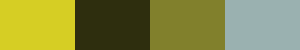

In [129]:
num_colors = 4
dominant_colors = get_dominant_colors(pixels=np.concatenate(persons_wo_black), k=num_colors)

display_dominant_colors(dominant_colors)

Dominant colors for the avg of colors of each person bounding boxes

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


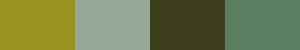

In [130]:
num_colors = 4
dominant_colors = get_dominant_colors(pixels=mean_colors, k=num_colors)

display_dominant_colors(dominant_colors)